In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys

sys.path.insert(0, "..")
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")

COLORS = ["#FF6B6B", "#4ECDC4", "#45B7D1", "#96CEB4", "#FFEAA7"]

print("Setup complete!")

Matplotlib is building the font cache; this may take a moment.


Setup complete!


In [2]:
# Load data
from ml.utils.data_utils import load_daily_aggregates, load_item_daily_sales

daily_sales = load_daily_aggregates()
item_sales = load_item_daily_sales()

print(f"Daily aggregate data: {len(daily_sales)} days")
print(f"Item-level data: {len(item_sales)} records")
print(f"Unique items: {item_sales['item_id'].nunique()}")

Daily aggregate data: 701 days
Item-level data: 47716 records
Unique items: 78


## 1. Data Exploration


In [3]:
# Examine daily sales
print("Daily Aggregate Sales:")
print(daily_sales.head())
print(f"\nDate range: {daily_sales['date'].min()} to {daily_sales['date'].max()}")

Daily Aggregate Sales:
        date  total_revenue  total_orders  total_items_sold  unique_customers  \
0 2024-01-01        1961.55            34               145                20   
1 2024-01-02        2331.60            49               190                32   
2 2024-01-03        2989.74            55               226                43   
3 2024-01-04        2362.25            44               175                27   
4 2024-01-05        2563.57            43               193                32   

   avg_order_value  day_of_week  is_weekend  month  year  
0            57.69            0       False      1  2024  
1            47.58            1       False      1  2024  
2            54.36            2       False      1  2024  
3            53.69            3       False      1  2024  
4            59.62            4       False      1  2024  

Date range: 2024-01-01 00:00:00 to 2025-12-01 00:00:00


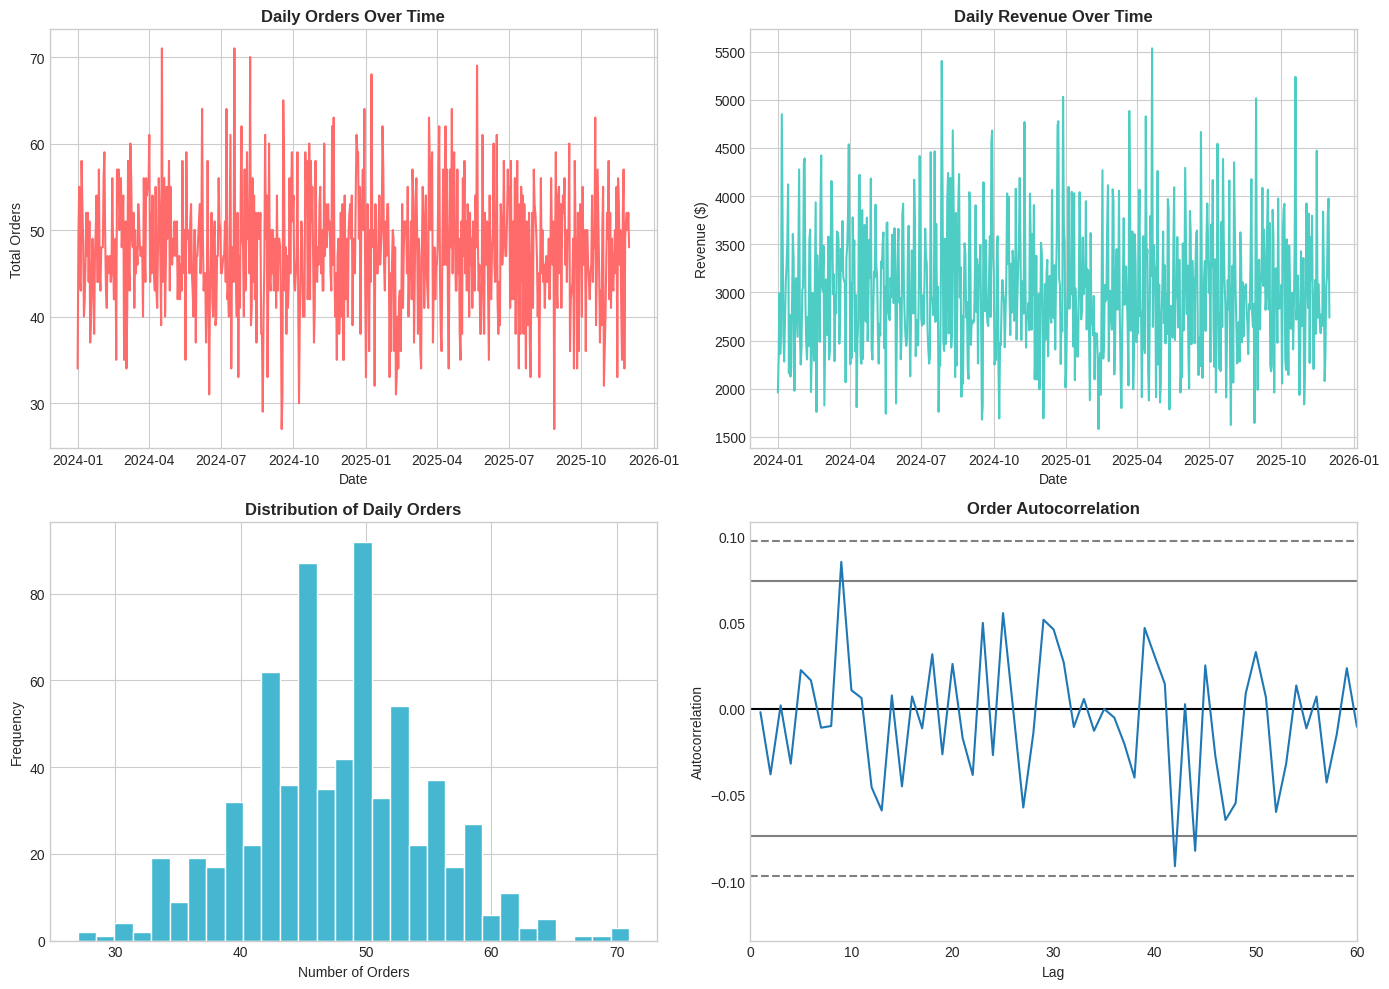

In [4]:
# Visualize time series
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total orders over time
axes[0, 0].plot(daily_sales["date"], daily_sales["total_orders"], color=COLORS[0])
axes[0, 0].set_title("Daily Orders Over Time", fontweight="bold")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Total Orders")

# Total revenue over time
axes[0, 1].plot(daily_sales["date"], daily_sales["total_revenue"], color=COLORS[1])
axes[0, 1].set_title("Daily Revenue Over Time", fontweight="bold")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Revenue ($)")

# Distribution of daily orders
axes[1, 0].hist(daily_sales["total_orders"], bins=30, color=COLORS[2], edgecolor="white")
axes[1, 0].set_title("Distribution of Daily Orders", fontweight="bold")
axes[1, 0].set_xlabel("Number of Orders")
axes[1, 0].set_ylabel("Frequency")

# Autocorrelation
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(daily_sales["total_orders"], ax=axes[1, 1])
axes[1, 1].set_title("Order Autocorrelation", fontweight="bold")
axes[1, 1].set_xlim([0, 60])

plt.tight_layout()
plt.show()

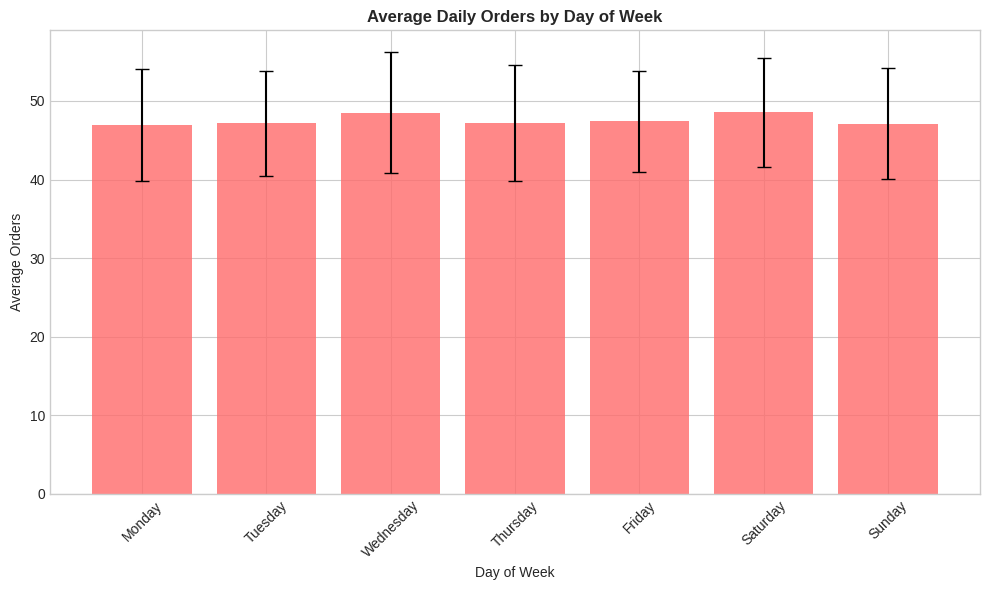

In [5]:
# Day of week patterns
daily_sales["date"] = pd.to_datetime(daily_sales["date"])
daily_sales["day_of_week"] = daily_sales["date"].dt.day_name()

dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_stats = (
    daily_sales.groupby("day_of_week")["total_orders"].agg(["mean", "std"]).reindex(dow_order)
)

plt.figure(figsize=(10, 6))
plt.bar(
    dow_stats.index, dow_stats["mean"], yerr=dow_stats["std"], capsize=5, color=COLORS[0], alpha=0.8
)
plt.title("Average Daily Orders by Day of Week", fontweight="bold")
plt.xlabel("Day of Week")
plt.ylabel("Average Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Feature Engineering


In [6]:
from ml.utils.data_utils import create_time_features, create_lag_features, create_rolling_features

# Create a copy for feature engineering
df = daily_sales.copy()

# Time features
df = create_time_features(df, date_col="date")
print("Time features created:")
print([c for c in df.columns if c not in daily_sales.columns])

Time features created:
['day_of_month', 'week_of_year', 'quarter', 'is_month_start', 'is_month_end']


In [7]:
# Lag features
df = create_lag_features(df, target_col="total_orders", lags=[1, 7, 14, 28])
print("\nLag features created:")
print([c for c in df.columns if "lag" in c])


Lag features created:
['total_orders_lag_1', 'total_orders_lag_7', 'total_orders_lag_14', 'total_orders_lag_28']


In [8]:
# Rolling features
df = create_rolling_features(df, target_col="total_orders", windows=[7, 14, 28])
print("\nRolling features created:")
print([c for c in df.columns if "rolling" in c])


Rolling features created:
['total_orders_rolling_mean_7', 'total_orders_rolling_std_7', 'total_orders_rolling_mean_14', 'total_orders_rolling_std_14', 'total_orders_rolling_mean_28', 'total_orders_rolling_std_28']


In [9]:
# Final feature set
print(f"\nTotal features: {len(df.columns) - 2}")
print(f"\nSample of engineered data:")
df.dropna().head()


Total features: 23

Sample of engineered data:


,date,total_revenue,total_orders,total_items_sold,unique_customers,avg_order_value,day_of_week,is_weekend,month,year,...,total_orders_lag_1,total_orders_lag_7,total_orders_lag_14,total_orders_lag_28,total_orders_rolling_mean_7,total_orders_rolling_std_7,total_orders_rolling_mean_14,total_orders_rolling_std_14,total_orders_rolling_mean_28,total_orders_rolling_std_28
28,2024-01-29,2575.64,45,186,25,57.24,0,0,1,2024,...,57.0,38.0,44.0,34.0,47.714286,6.499084,46.000000,5.804508,46.714286,6.078847
29,2024-01-30,2251.24,43,176,30,52.35,1,0,1,2024,...,45.0,47.0,51.0,49.0,48.714286,5.154748,46.071429,5.784120,47.107143,5.560038
30,2024-01-31,2424.99,48,201,29,50.52,2,0,1,2024,...,43.0,50.0,37.0,55.0,48.142857,5.580579,45.500000,5.653454,46.892857,5.599863
31,2024-02-01,3027.39,48,211,36,63.07,3,0,2,2024,...,48.0,54.0,40.0,44.0,47.857143,5.520524,46.285714,5.120525,46.642857,5.376315
32,2024-02-02,3050.51,48,249,33,63.55,4,0,2,2024,...,48.0,44.0,46.0,43.0,47.000000,4.830459,46.857143,4.801557,46.785714,5.356596


## 3. Model Training


In [10]:
from ml.pipelines.demand_forecasting import DemandForecaster

# Train basic forecaster
forecaster = DemandForecaster(
    target_col="total_orders", lags=[1, 7, 14, 21, 28], rolling_windows=[7, 14, 28]
)

# Use fresh data
train_df = load_daily_aggregates()
metrics = forecaster.train(train_df)

print("\nTraining Complete!")
print("=" * 40)
for metric, value in metrics.items():
    print(f"  {metric}: {value:.4f}")

Preparing features...
Training LightGBM model...

Training complete!
Train RMSE: 0.2302
Val RMSE: 1.4390
Val R²: 0.9545

Training Complete!
  train_mae: 0.1334
  train_rmse: 0.2302
  train_r2: 0.9990
  val_mae: 1.0581
  val_rmse: 1.4390
  val_r2: 0.9545


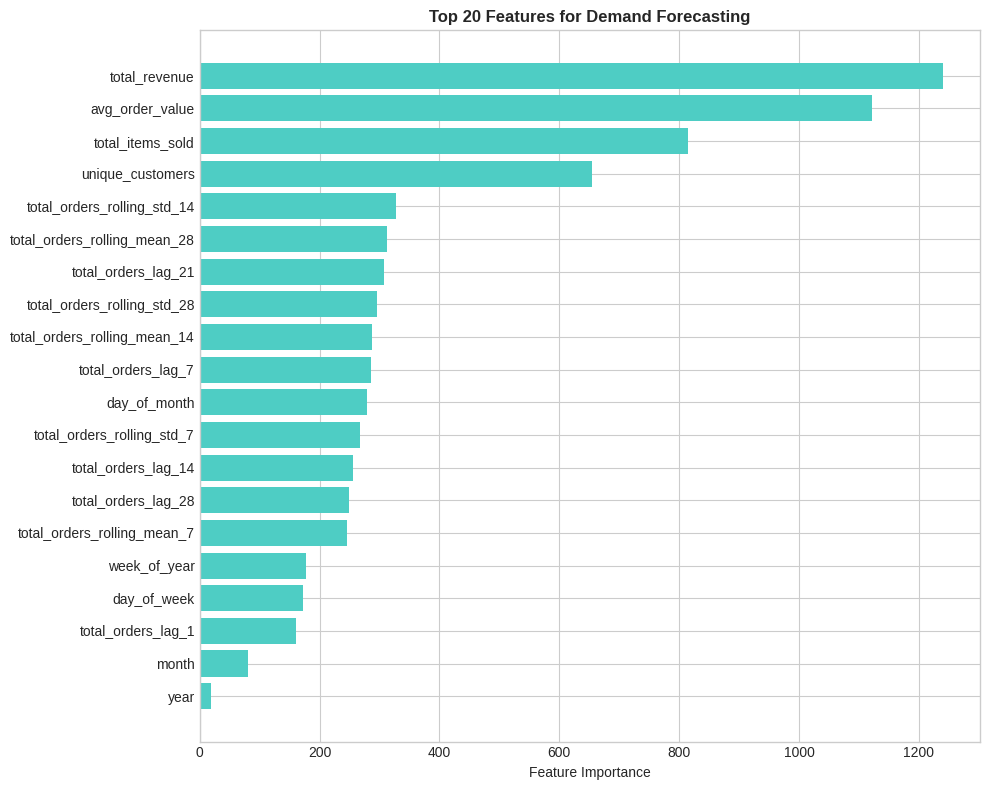

In [11]:
# Feature importance
importance = forecaster.get_feature_importance(20)

plt.figure(figsize=(10, 8))
plt.barh(importance["feature"], importance["importance"], color=COLORS[1])
plt.title("Top 20 Features for Demand Forecasting", fontweight="bold")
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. Hyperparameter Optimization with Optuna


In [12]:
from ml.pipelines.enhanced_forecasting import EnhancedDemandForecaster

# Initialize enhanced forecaster
enhanced_forecaster = EnhancedDemandForecaster(
    target_col="total_orders", lags=[1, 7, 14, 21, 28], rolling_windows=[7, 14, 28]
)

# Train with optimization (reduced trials for demo)
train_df = load_daily_aggregates()
results = enhanced_forecaster.train_with_optimization(
    train_df,
    n_trials=20,  # Increase for better results
    n_cv_splits=3,
    experiment_name="demand_forecast_notebook",
)

print("\nOptimization Complete!")

Preparing features...
Training LightGBM model...

Training complete!
Train RMSE: 0.2302
Val RMSE: 1.4390
Val R²: 0.9545

Optimization Complete!


In [13]:
# Best parameters
print("\nBest Hyperparameters:")
print("=" * 40)
for param, value in results["best_params"].items():
    print(f"  {param}: {value}")


Best Hyperparameters:


KeyError: 'best_params'

In [14]:
# Final metrics
print("\nFinal Model Metrics:")
print("=" * 40)
for metric, value in results["metrics"].items():
    print(f"  {metric}: {value:.4f}")


Final Model Metrics:


KeyError: 'metrics'

In [15]:
# Optimization history
history = pd.DataFrame(results["optimization_history"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Optimization progress
axes[0].plot(history["trial"], history["value"], "o-", color=COLORS[0], alpha=0.7)
axes[0].axhline(
    history["value"].min(),
    color="green",
    linestyle="--",
    label=f"Best: {history['value'].min():.4f}",
)
axes[0].set_title("Optimization Progress", fontweight="bold")
axes[0].set_xlabel("Trial")
axes[0].set_ylabel("CV Score (RMSE)")
axes[0].legend()

# Score distribution
axes[1].hist(history["value"], bins=20, color=COLORS[1], edgecolor="white")
axes[1].axvline(history["value"].min(), color="green", linestyle="--", label="Best")
axes[1].set_title("Score Distribution Across Trials", fontweight="bold")
axes[1].set_xlabel("CV Score (RMSE)")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

KeyError: 'optimization_history'

## 5. Model Explainability with SHAP


In [16]:
# Get SHAP explanations
# Prepare test data
test_df = enhanced_forecaster._prepare_features(train_df, is_training=False)
test_df = test_df.dropna()

explanations = enhanced_forecaster.explain_predictions(
    test_df[enhanced_forecaster.feature_cols].tail(100), num_features=15
)

print("\nSHAP-based Feature Importance:")
shap_importance = pd.DataFrame(explanations["feature_importance_shap"])
shap_importance


SHAP-based Feature Importance:


KeyError: 'feature_importance_shap'

In [17]:
# SHAP visualization
try:
    import shap

    # Create SHAP summary plot
    X = test_df[enhanced_forecaster.feature_cols].tail(100)
    explainer = shap.TreeExplainer(enhanced_forecaster.model)
    shap_values = explainer.shap_values(X)

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, plot_type="bar", max_display=15, show=False)
    plt.title("SHAP Feature Importance", fontweight="bold")
    plt.tight_layout()
    plt.show()
except ImportError:
    print("SHAP not installed. Install with: pip install shap")

SHAP not installed. Install with: pip install shap


## 6. Generate Forecasts


In [18]:
# Generate 14-day forecast
historical = load_daily_aggregates()
forecast = enhanced_forecaster.forecast_future(historical, days_ahead=14)

print("\n14-Day Forecast:")
forecast

ValueError: Input data must be 2 dimensional and non empty.

NameError: name 'forecast' is not defined

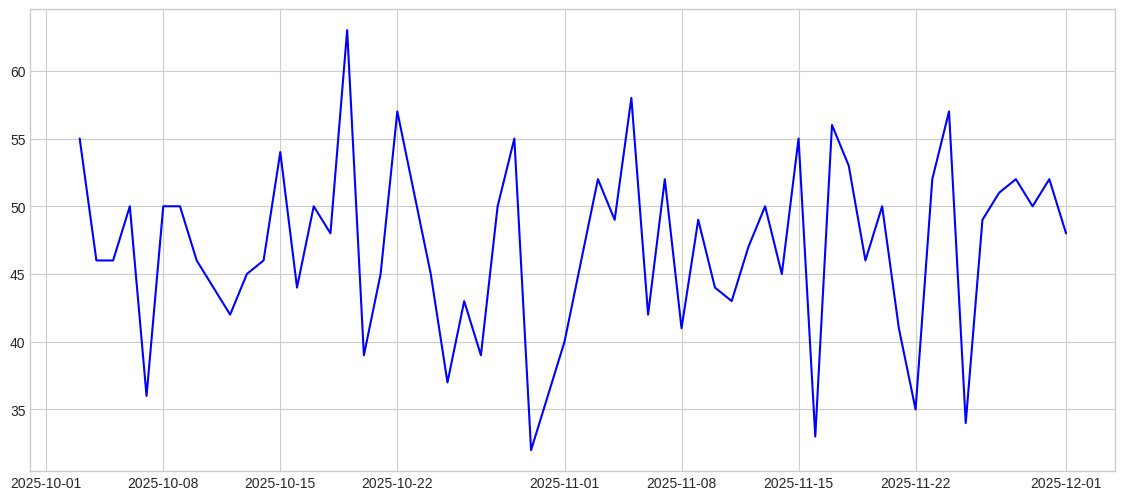

In [19]:
# Visualize forecast
fig, ax = plt.subplots(figsize=(14, 6))

# Historical data (last 60 days)
recent = historical.tail(60).copy()
ax.plot(recent["date"], recent["total_orders"], "b-", label="Historical", linewidth=1.5)

# Forecast
if len(forecast) > 0:
    ax.plot(forecast["date"], forecast["total_orders"], "r--", label="Forecast", linewidth=2)
    ax.scatter(forecast["date"], forecast["total_orders"], color="red", s=50, zorder=5)

ax.axvline(historical["date"].max(), color="gray", linestyle=":", alpha=0.7)
ax.set_title("Demand Forecast - Next 14 Days", fontweight="bold", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Total Orders")
ax.legend()
plt.tight_layout()
plt.show()

## 7. Item-Level Forecasting


In [20]:
# Train item-level forecaster
from ml.pipelines.demand_forecasting import train_item_level_forecaster

item_forecaster, item_metrics = train_item_level_forecaster()

print("\nItem-Level Forecaster Metrics:")
for metric, value in item_metrics.items():
    print(f"  {metric}: {value:.4f}")

TRAINING ITEM-LEVEL DEMAND FORECASTER
Preparing features...
Training LightGBM model...

Training complete!
Train RMSE: 0.4263
Val RMSE: 0.5125
Val R²: 0.9440
Model saved to /home/ashour/Restaurant_AI-1/notebooks/../ml/models/demand_forecaster_item_level.pkl

Item-Level Forecaster Metrics:
  train_mae: 0.2480
  train_rmse: 0.4263
  train_r2: 0.9625
  val_mae: 0.2829
  val_rmse: 0.5125
  val_r2: 0.9440


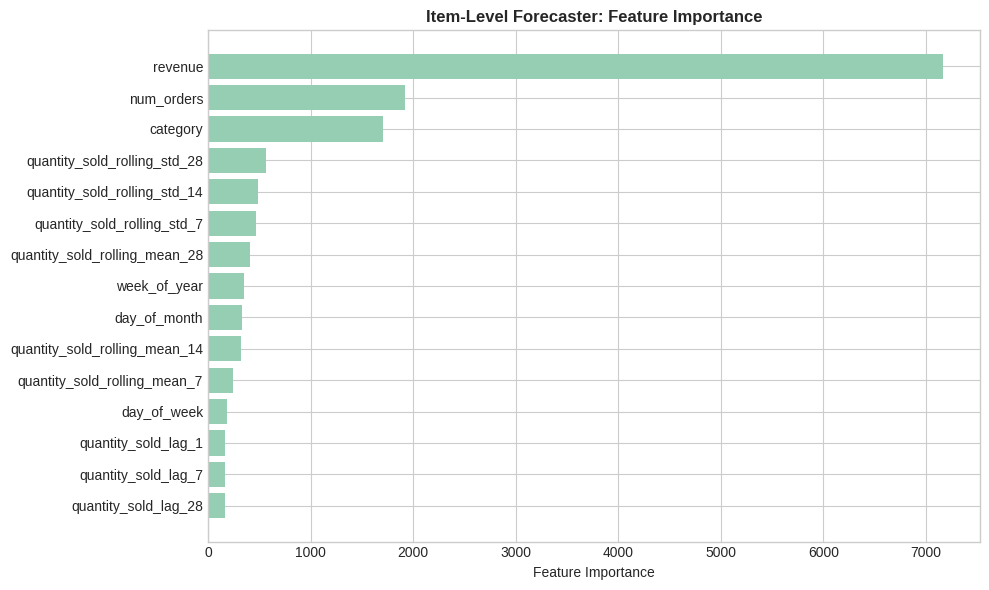

In [21]:
# Item-level feature importance
item_importance = item_forecaster.get_feature_importance(15)

plt.figure(figsize=(10, 6))
plt.barh(item_importance["feature"], item_importance["importance"], color=COLORS[3])
plt.title("Item-Level Forecaster: Feature Importance", fontweight="bold")
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Cross-Validation Analysis


In [22]:
# Run cross-validation
cv_results = enhanced_forecaster.cross_validate(load_daily_aggregates(), n_splits=5)

print("\nCross-Validation Results:")
print("=" * 40)
for metric, value in cv_results.items():
    print(f"  {metric}: {value:.4f}")

INFO:ml.pipelines.enhanced_forecasting:Performing 5-fold time series cross-validation...
INFO:ml.pipelines.enhanced_forecasting:Fold 1: RMSE=3.4570
INFO:ml.pipelines.enhanced_forecasting:Fold 2: RMSE=2.6179
INFO:ml.pipelines.enhanced_forecasting:Fold 3: RMSE=1.9707
INFO:ml.pipelines.enhanced_forecasting:Fold 4: RMSE=1.8064
INFO:ml.pipelines.enhanced_forecasting:Fold 5: RMSE=1.4949
INFO:ml.pipelines.enhanced_forecasting:CV RMSE: 2.2694 (+/- 0.6979)



Cross-Validation Results:
  cv_mae_mean: 1.6480
  cv_mae_std: 0.4623
  cv_rmse_mean: 2.2694
  cv_rmse_std: 0.6979
  cv_r2_mean: 0.8950
  cv_r2_std: 0.0626


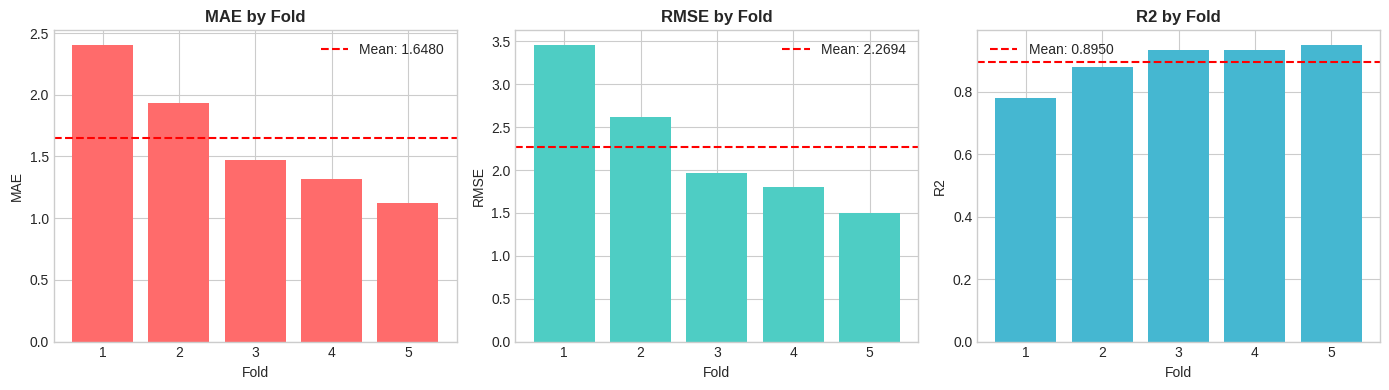

In [23]:
# Visualize CV results
cv_scores = enhanced_forecaster.cv_results

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, (metric, scores) in enumerate(cv_scores.items()):
    axes[i].bar(range(1, len(scores) + 1), scores, color=COLORS[i])
    axes[i].axhline(
        np.mean(scores), color="red", linestyle="--", label=f"Mean: {np.mean(scores):.4f}"
    )
    axes[i].set_title(f"{metric.upper()} by Fold", fontweight="bold")
    axes[i].set_xlabel("Fold")
    axes[i].set_ylabel(metric.upper())
    axes[i].legend()

plt.tight_layout()
plt.show()

## 9. Model Summary


In [24]:
# Get optimization summary
summary = enhanced_forecaster.get_optimization_summary()

print("\nOptimization Summary:")
print("=" * 50)
print(f"  Total Trials: {summary['n_trials']}")
print(f"  Best Score: {summary['best_score']:.4f}")
print(f"  Worst Score: {summary['worst_score']:.4f}")
print(f"  Mean Score: {summary['mean_score']:.4f}")
print(f"  Improvement: {summary['improvement']:.1f}%")
print(f"\nBest Parameters: {summary['best_params']}")


Optimization Summary:


KeyError: 'n_trials'

In [25]:
# Save model
enhanced_forecaster.save("demand_forecaster_notebook")
print("\n[OK] Model saved successfully!")

Model saved to /home/ashour/Restaurant_AI-1/notebooks/../ml/models/demand_forecaster_notebook.pkl

[OK] Model saved successfully!
